# Solving the Poisson equation

To solve $\Delta u = f$, our approach is the same as for the 1D TPBVP. We discretize the functions and differentiation operators, collocate the PDE at interior nodes, and collocate boundary conditions at boundary nodes, all to get a square linear algebraic system. For rectangular domains, this process is pretty straightforward.

## Kronecker product

If $\bfU$ is the matrix discretization of a function $u(x,y)$ on the rectangle, then we can discretize the action of the Laplacian as

$$
\Delta u = \partial_{xx} u + \partial_{yy} u \approx \bfD_{xx} \bfU + \bfU \bfD_{yy}^T. 
$$

where $\bfD_{xx}$ and $\bfD_{yy}$ are 1D differentiation matrices. If we collocate at all of the nodes, then, we get an equation of the form

$$
\bfD_{xx} \bfU + \bfU \bfD_{yy}^T = \bfF. 
$$

This is known as a **Sylvester equation**. There are methods for solving it, but they are not of the familiar type with LU factorization, etc. To use those methods, we need a *vector* of unknowns, 

$$
\bfu = \myvec(\bfU). 
$$

Fortunately we have a handy identity to exploit:

$$
\myvec(\bfA\mathbf{B}\bfC) = (\bfC^T \otimes \bfA ) \myvec(\mathbf{B}), 
$$

where $\otimes$ is the **Kronecker matrix product,**

:::{math}
    :label: krondef
    \mathbf{A}\otimes \mathbf{B} =
    \begin{bmatrix}
    A_{11} \mathbf{B} & A_{12}\mathbf{B} & \cdots & A_{1n}\mathbf{B} \\
    A_{21} \mathbf{B} & A_{22}\mathbf{B} & \cdots & A_{2n}\mathbf{B} \\
    \vdots & \vdots &  & \vdots \\
    A_{m1} \mathbf{B} & A_{m2}\mathbf{B} & \cdots & A_{mn}\mathbf{B}
    \end{bmatrix}.
:::

The Kronecker product obeys several other notable identities:

1. $\mathbf{A}\otimes (\mathbf{B} + \mathbf{C})   = \mathbf{A}\otimes \mathbf{B} + \mathbf{A}\otimes \mathbf{C}$  
2. $(\mathbf{A} + \mathbf{B}) \otimes \mathbf{C}   = \mathbf{A}\otimes \mathbf{C} + \mathbf{B}\otimes \mathbf{C}$  
3. $(\mathbf{A} \otimes \mathbf{B}) \otimes \mathbf{C}   =  \mathbf{A} \otimes (\mathbf{B} \otimes \mathbf{C})$ 
4. $(\mathbf{A} \otimes \mathbf{B})^T  =  \mathbf{A}^T \otimes \mathbf{B}^T$  
5. $(\mathbf{A} \otimes \mathbf{B})^{-1}  =  \mathbf{A}^{-1} \otimes \mathbf{B}^{-1}$  
6. $(\mathbf{A} \otimes \mathbf{B})(\mathbf{C}\otimes \mathbf{D})  =  (\mathbf{A}\mathbf{C}) \otimes (\mathbf{B}\mathbf{D})$

Defining $\bfu=\myvec(\bfU)$ and $\bff=\myvec(\bfF)$, the collocated Poisson equation is

$$
\underbrace{\bigl[ ({\mathbf{I}_{y}} \otimes {\mathbf{D}_{xx}}) + ({\mathbf{D}_{yy}}\otimes {\mathbf{I}_{x}})\bigr]}_{\mathbf{A}} \, \mathbf{u} = \mathbf{f},
$$

where $\mathbf{I}_{x}$ and $\mathbf{I}_{y}$ are the $(m+1)\times (m+1)$ and $(n+1)\times (n+1)$ identities, respectively.

## Dirichlet conditions

The easiest way to incorporate the boundary conditions is to replace the PDE at each boundary node with a discretized form of the BC. This means altering rows of the matrix $\bfA$ resulting from discretizing the interior. For a Dirichlet condition, the new row is just a row of the superidentity $\mathbf{I}_{y} \otimes \mathbf{I}_{y}$. We could clearly "solve" such rows manually and do algebra to remove the corresponding node from the unknowns, but the amount of additional work incurred by leaving them in is usually negligible. 

Here is a forcing function for Poisson's equation.

In [1]:
f = (x,y) -> x^2 - y + 2;

We make a crude discretization for illustrative purposes.

In [2]:
include("diffmats.jl")
m,n = 7,5
x,Dx,Dxx = diffmats(m,0,3)
y,Dy,Dyy = diffmats(n,-1,1)
unvec = u -> reshape(u,m+1,n+1);

Next, we evaluate $f$ on the grid.

In [3]:
F = [ f(x,y) for x in x, y in y ]

8×6 Matrix{Float64}:
  3.0       2.6       2.2       1.8       1.4       1.0
  3.18367   2.78367   2.38367   1.98367   1.58367   1.18367
  3.73469   3.33469   2.93469   2.53469   2.13469   1.73469
  4.65306   4.25306   3.85306   3.45306   3.05306   2.65306
  5.93878   5.53878   5.13878   4.73878   4.33878   3.93878
  7.59184   7.19184   6.79184   6.39184   5.99184   5.59184
  9.61224   9.21224   8.81224   8.41224   8.01224   7.61224
 12.0      11.6      11.2      10.8      10.4      10.0

Here are the equations for the PDE collocation, before any modifications are made for the boundary conditions.

In [4]:
A = kron(I(n+1),Dxx) + kron(Dyy,I(m+1))
b = vec(F);

The number of equations is equal to $(m+1)(n+1)$, which is the total number of points on the grid.

In [5]:
@show N = length(F);

N = length(F) = 48


The combination of Kronecker products and finite differences produces a characteristic sparsity pattern.

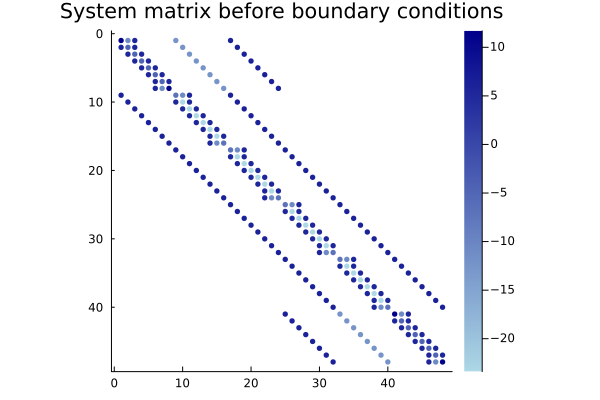

In [6]:
using Plots
spy(sparse(A),color=:blues,m=3,
    title="System matrix before boundary conditions")

We now construct a Boolean array the same size as `F` to indicate where the boundary points lie in the grid.

In [7]:
isboundary = trues(m+1,n+1)
isboundary[2:m,2:n] .= false
idx = vec(isboundary);

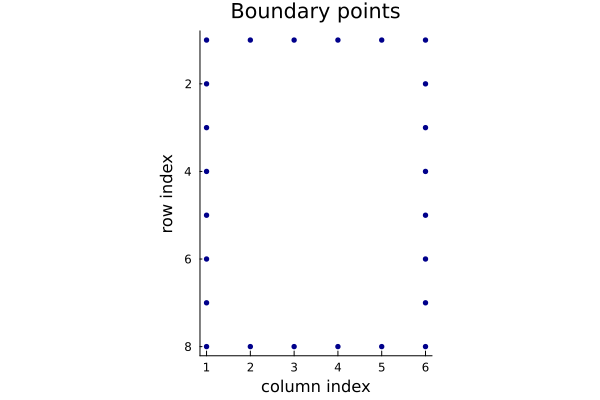

In [8]:
spy(sparse(isboundary),m=3,color=:darkblue,legend=:none,
    title="Boundary points",
    xaxis=("column index",[0,n+2]),yaxis=("row index",[0,m+2]) )

In order to impose Dirichlet boundary conditions, we replace the boundary rows of the system by rows of the identity.

In [9]:
I_N = I(N)
A[idx,:] .= I_N[idx,:];     # Dirichlet conditions

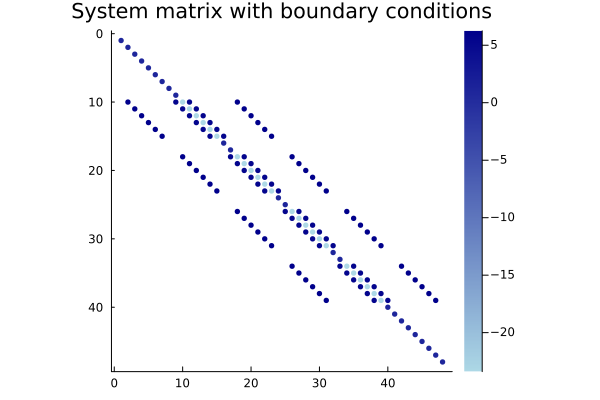

In [10]:
spy(sparse(A),color=:blues,m=3,
    title="System matrix with boundary conditions")    

Finally, we must replace the rows in the vector $\mathbf{b}$ by the boundary values being assigned to the boundary points. Here, we let the boundary values be 1 everywhere.

In [11]:
b[idx] .= 1;                 # Dirichlet values

Now we can solve for $\mathbf{u}$ and reinterpret it as the matrix-shaped $\mathbf{U}$, the solution on our grid.

In [12]:
u = A\b
U = unvec(u)

8×6 Matrix{Float64}:
 1.0   1.0        1.0        1.0        1.0        1.0
 1.0   0.509076   0.327231   0.37017    0.598914   1.0
 1.0   0.174627  -0.165761  -0.108608   0.290864   1.0
 1.0  -0.104071  -0.57609   -0.514796   0.0194179  1.0
 1.0  -0.327163  -0.890936  -0.829642  -0.203674   1.0
 1.0  -0.409269  -0.979476  -0.922322  -0.293032   1.0
 1.0  -0.133634  -0.54072   -0.497781  -0.0437956  1.0
 1.0   1.0        1.0        1.0        1.0        1.0

### Implementation

In [13]:
include("poisson.jl")
foreach(println,readlines("poisson.jl"))

include("diffmats.jl")
function poissonfd(f,g,m,xspan,n,yspan)
    # Discretize the domain.
    x,Dx,Dxx = diffmats(m,xspan...)
    y,Dy,Dyy = diffmats(n,yspan...)
    grid = [(x,y) for x in x, y in y]
    N = (m+1)*(n+1)   # total number of unknowns

    # Form the collocated PDE as a linear system.
    A = kron(I(n+1),Dxx) + kron(Dyy,I(m+1))
    b = vec( f.(grid) )

    # Identify boundary locations.
    isboundary = trues(m+1,n+1)
    isboundary[2:m,2:n] .= false
    idx = vec(isboundary)

    # Apply Dirichlet condition.
    scale = maximum(abs,A[n+2,:])
    A[idx,:] = scale * I(N)[idx,:]        # Dirichlet assignment
    b[idx] = scale * g.(grid[idx])    # assigned values

    # Solve the linear system and reshape the output.
    u = A\b
    U = reshape(u,m+1,n+1)
    return x,y,U
end


We can engineer an example by choosing the solution first. Let $u(x,y)=\sin(3xy-4y)$. Then one can derive $f=\Delta u = -\sin(3xy-4y)\bigl(9y^2+(3x-4)^2\bigr)$ for the forcing function and use $g=u$ on the boundary.

First we define the problem on $[0,1]\times[0,2]$.

In [14]:
f = x -> -sin(3x[1]*x[2]-4x[2]) * (9x[2]^2+(3x[1]-4)^2)
g = x -> sin(3x[1]*x[2]-4x[2])
xspan = [0,1];  yspan = [0,2];

Here is the finite-difference solution.

In [15]:
x,y,U = poissonfd(f,g,40,xspan,60,yspan);

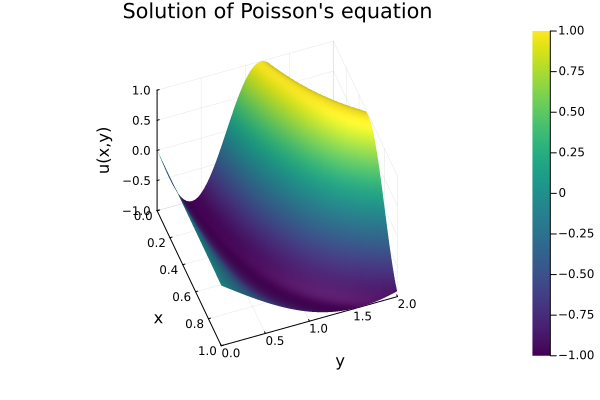

In [16]:
surface(x,y,U',color=:viridis,
    title="Solution of Poisson's equation",      
    xaxis=("x"),yaxis=("y"),zaxis=("u(x,y)"),
    right_margin=3Plots.mm,camera=(70,50))    

The error is a smooth function of $x$ and $y$. It must be zero on the boundary; otherwise, we have implemented boundary conditions incorrectly.

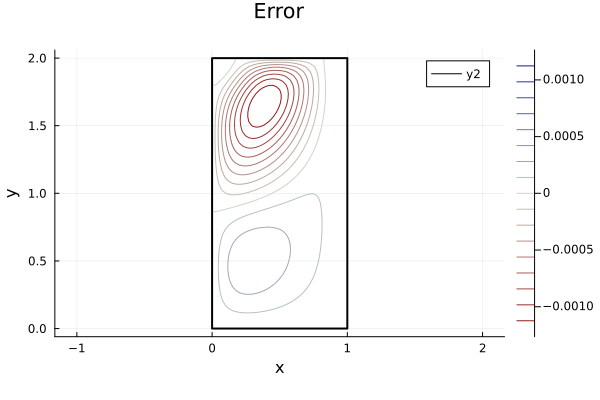

In [17]:
error = [g([x,y]) for x in x, y in y] - U;
M = maximum(abs,error)
contour(x,y,error',levels=17,aspect_ratio=1,
    clims=(-M,M),color=:redsblues,colorbar=:bottom,
    title="Error",xaxis=("x"),yaxis=("y"),
    right_margin=7Plots.mm)
plot!([0,1,1,0,0],[0,0,2,2,0],l=(2,:black))

## Neumann conditions

If we use the boundary row replacement method, generalizing the above to Neumann conditions can be surprisingly easy. The key steps for the Dirichlet case were to define a vector `idx` indicating which rows correspond to boundary nodes, and then make replacements:

:::{code-block} julia
A[idx,:] .= I(N)[idx,:]    # Dirichlet conditions
b[idx] .= g.(grid[idx])     # Dirichlet values
:::

(We're ignoring the row scaling step for simplicity.) 

For a Neumann condition, all we have to do is swap the identity operator (matrix) for one that computes the outward normal derivatives. In the homogeneous case, we don't even need to be concerned with the distinction between inward and outward normals. The only new complication is that we need different operators for the boundaries in the $x$ and $y$ directions. For example, to impose homogeneous Neumann conditions along both edges with constant $x$ values, we use

:::{code-block} julia
xboundary = trues(m+1,n+1)
xboundary[2:m,:] .= false
idx = vec(xboundary)
A[idx,:] .= kron(I(n+1),Dx)[idx,:]    # Neumann conditions
b[idx] .= 0                           # Neumann values
:::

## Sparsity

The implementation of `diffmats` changed just a bit from the 1D case:

In [18]:
foreach(println,readlines("diffmats.jl"))

using LinearAlgebra,SparseArrays
function diffmats(m,a,b)
    # assumes evenly spaced nodes
    h = (b-a)/m
    x = [ a+i*h for i in 0:m ]
    Dx = 1/2h*spdiagm(-1=>[-ones(m-1);-2],0=>[-2;zeros(m-1);2],1=>[2;ones(m-1)])
    Dxx = 1/h^2*spdiagm(-1=>[ones(m-1);-2],0=>[1;-2*ones(m-1);1],1=>[-2;ones(m-1)])
    Dxx[m+1,m-1] = Dxx[1,3] = 1/h^2
    return x,Dx,Dxx
end


The differentiation matrices are returned in **sparse** form. While they are sparse even considered as 1D matrices, the sizes were too small to worry about it then. But now we should be more careful. The system matrix is of size $O(mn)$, while the number of nonzero elements per row is small and bounded by constant. 

Say $m=O(n)$ for simplicity. Then a naive dense factorization of the system would take $O(n^6)$ operations. Exploiting sparsity, the count should be no more than $O(n^4)$, which still grows quickly but is far better.

## Nonlinear problems

A nonlinear elliptic PDE, like a nonlinear TPBVP, leads to a nonlinear algebraic system. As before, we usually want to apply a quasi-Newton method to solve that system. This will entail the solution of multiple linear systems with a changing matrix (Jacobian or approximation). 

Unless $m$ and $n$ are quite small, the linear solver within the nonlinear iterations will have to support sparsity. Some solvers accept a sparsity pattern that they can exploit; in most cases you are best off supplying your own Jacobian.

For example, to solve 

$$
\epsilon \Delta u + u u_x + 1 = 0, 
$$

with Dirichlet boundary value 1, note that the linearization of the PDE around function $u_0$ is 

$$
\epsilon \Delta + u_0 \partial_x + (\partial_x u_0),
$$

and it has homogeneous Dirichlet BC.

In [19]:
include("diffmats.jl")
n = 60
x,Dx,Dxx = diffmats(n,0,1)
y,Dy,Dyy = diffmats(n,0,1)
bdy = trues(n+1,n+1)
bdy[2:n,2:n] .= false
bdy = vec(bdy)

function residual(u) 
    U = reshape(u,n+1,n+1)
    R = 0.05*(Dxx*U + U*Dyy') + U.*(Dx*U) .+ 1
    R[bdy] .= U[bdy] .- 1
    return vec(R)
end;

function jac(u)
    L = kron(I(n+1),Dxx) + kron(Dyy,I(n+1))
    U_x = Dx*reshape(u,n+1,n+1)
    J = 0.05L + spdiagm(u)*kron(I(n+1),Dx) + spdiagm(vec(U_x))
    J[bdy,:] .= 0
    J[bdy,bdy] .= I(count(bdy))
    return J
end;

In [20]:
using NLsolve
sol = nlsolve(residual,jac,vec(zeros(n+1,n+1)));
sol.residual_norm

3.015365734881925e-13

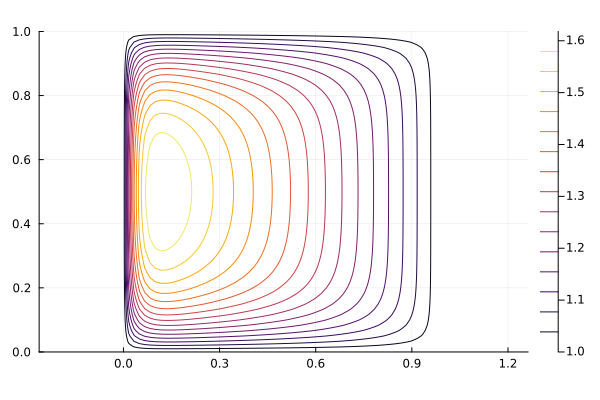

In [21]:
contour(x,y,reshape(sol.zero,n+1,n+1)',aspect_ratio=1)